# EDA анализ продаж игр

В данном проект мы решаем задачу прогнозирования кампании, которая должна проводиться интернет-магазином игр в 2017 году. Для этого нам предоставлен файл в формате "csv".
 
 Первым делом мы должны разобраться с пропусками, дубликатами, форматом данных - провести соответствующую подготовку для проведения корректного анализа. Далее, объединив все продажи в целом, следует рассмотерть их изменение во времени для разных платформ. Определить актуальный период времени, который мы будем учитывать в исследовании, а также какие платформы более успешные к 2016 году и могут быть прибыльными к 2017 году. Стоит взглянуть на размах значений общих продаж в их разбивке по платформам. 
 
 Кроме того, следует разобраться с тем, как влияют отзывы критиков и пользователей на продажи. Это можно сделать на примере одной платформы и соотнести с несколькими другими. Вместе с этим необходимо понимать и какие жанры наиболее популярны, приносят больше продаж.
 
 Помимо общего анализа логично изучить, что предпочитают пользователи каждого региона (платформы, жанры).
 
 Последним шагом можно сформулировать некоторые гипотезы по поводу рейтингов разных платформ, жанров, сравнить их.

##  Открытие файла, изучение общей информации

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('YP/games.csv')

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Пропусков в Name, Year_of_Release, Genre, явно не много (посмотрим ниже, конечно дубликаты, но если что, просто удалим строки даже, т.к. нам погоды они не сыграют на шестнадцатитысячной выборке), а вот в трех последних колонках (оценки разных источников) немало (40% и выше), их придется либо пропустить, либо чем-то заполнить. Ноли в столбцах продаж с регионами, скорее всего, просто говорят о том, что в данном регионе не продавалась игра. 

##  Подготовка данных

###  Предварительные оценки

In [4]:
# приведем столбцы к нижнему регистру
data.columns = data.columns.str.lower()


Пропуски в колонках с оценками возникли либо из-за того, что игра не популярна (платформа может) и никто такой показатель не ставил целью исследования, либо как раз из-за того, что их предстоит определить (вдруг 0 - по факту tbd, об этом ниже). Год релиза в любом случае должен существовать (может для мелких студий, игр его и не указывает никто, потому что просто игра вышла в свет и вышла), но возможно, что и релиз переносили с года на год, и просто эти данные не внесли никуда.

### Поиск дубликатов

In [5]:
display(data[data.duplicated() == True])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Явных дубликатов нет. Обратим внимание на то, что лучше объединить платформу и название, взглянув на дубликаты в такой связке. Проверим, что у нас имеется хотя бы по одной (любой) игре.

In [6]:
data[(data['name'] == 'Need for Speed: Most Wanted')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Имеются "перезаливы" для некоторых платформ и пропуски в некоторых ячейках.

### Обработка пропусков

Очевидно, что если год релиза пропущен нужно либо найти его вручную, либо избавиться от таких пропусков. Заодно приведем тип к удобному для сравнения.

In [7]:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)
data['year_of_release'] = data['year_of_release'].astype('int')

Здесь же обработаем и значения tbd, они по своей сути тоже пропуски, которые должны быть определены (по факту правда не нами, а пользователями, укоторых нужно узнать оценки).

<AxesSubplot:>

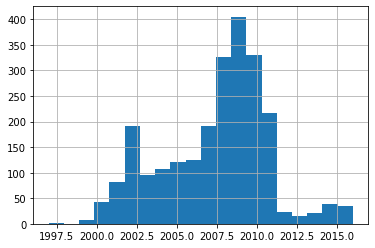

In [8]:
year_tbd = data[data['user_score'] == 'tbd']['year_of_release']
year_tbd.hist(bins=20)


Одназначно оценки сильно не заполнялись в 2006...2011 годах. После этого их стало в разы меньше. До этого у них был период, когда о таком, видимо совсем не знали (в смысле и термин не придумали), потом был плавный рост с конца девяностых до 2006 с одним всплеском. В любом случае, считаю нецелесообразным здесь заполнять медианным значением по группам годов оценки, т.к. пользователи могли влепить везде любую оценку (у нас медианное может быть 7.5, а на самом деле там 5 будет - это не вариант, на мой взгляд).



In [9]:
# пока решаем присвоить всем 'tbd' NaN, чтобы потом работать со столбцом
data.loc[data['user_score'] == 'tbd', 'user_score'] = "NaN"
data['user_score'] = data['user_score'].astype('float32')
#data['user_score'].unique()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(1), float64(5), int32(1), object(4)
memory usage: 1.3+ MB


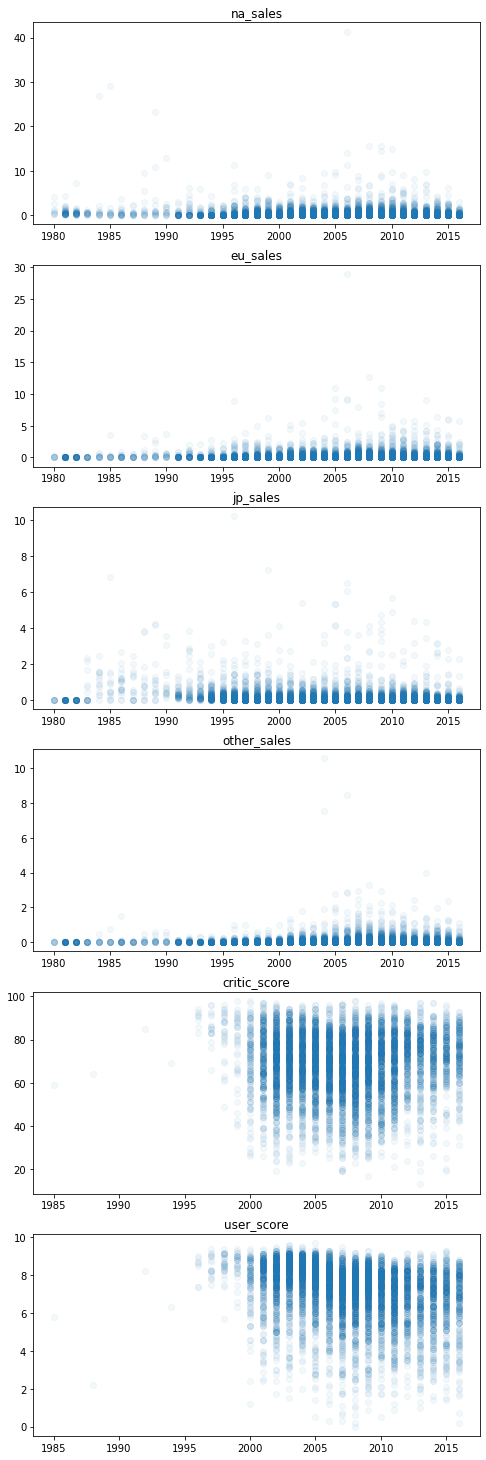

0.579670625121847


In [10]:
# предварительно посмотрим на продажи по годам
# и сравним оценки критиков и пользователей
plt.figure(figsize=(8, 26))
df = data.set_index('year_of_release')

numeric_columns = data.select_dtypes(include=['float']).columns

for i, colname in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 1, i+1)
    plt.plot(df[colname], 'o', alpha=0.05)
    plt.title(colname)
plt.show()
print(data['user_score'].corr(data['critic_score']))


Похоже нас хоть как-то будут интересовать годы только после 2000, т.к. до этого и оценок никто особо не ставил, и продажи были явно ниже (за исключением некоторых индивидуальных случаев. Дальше на количество их в разные годы группировкой посмотрим еще.

Однозначно линейная корреляция у оценок критиков и пользователей есть. 


###  Определение суммы общих продаж

In [11]:
data['sales_sum'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [12]:
# Посмотрим, что у нас осталось из пропусков
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
 11  sales_sum        16446 non-null  float64
dtypes: float32(1), float64(6), int32(1), object(4)
memory usage: 1.4+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' '¡Shin Chan Flipa en colores!' nan]
n

## Проведение исследовательского анализа

### Определение колличества выпущенных игр по годам

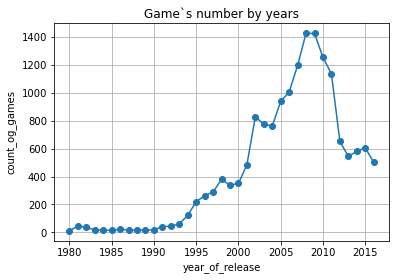

In [13]:
games_amount = data.groupby('year_of_release').agg({'name': 'count'}).reset_index()
games_amount.plot(x='year_of_release', y='name', grid=True, style='o-', legend=False, ylabel='count_og_games', title=\
                  'Game`s number by years')
plt.show()

Видно, что крайне мало игр разрабатывалось и продавалось до 2000 года. Поэтому от них сразу же избавимся. В целом отметим, что распределение напоминает нормальное - в 2008, 2009 гг. явно был пик.


In [14]:
data = data[data['year_of_release'] > 2000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14120 entries, 0 to 16445
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14120 non-null  object 
 1   platform         14120 non-null  object 
 2   year_of_release  14120 non-null  int32  
 3   genre            14120 non-null  object 
 4   na_sales         14120 non-null  float64
 5   eu_sales         14120 non-null  float64
 6   jp_sales         14120 non-null  float64
 7   other_sales      14120 non-null  float64
 8   critic_score     7744 non-null   float64
 9   user_score       7264 non-null   float32
 10  rating           9515 non-null   object 
 11  sales_sum        14120 non-null  float64
dtypes: float32(1), float64(6), int32(1), object(4)
memory usage: 1.3+ MB


### Определение продуктивных платформ

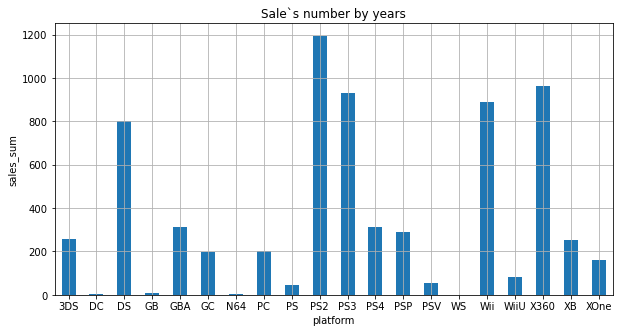

In [15]:
pop_platform = data.groupby('platform').agg({'sales_sum': 'sum'}).reset_index()
pop_platform.plot(x='platform', y='sales_sum', grid=True, kind='bar', legend=False, ylabel='sales_sum', title=\
                  'Sale`s number by years', figsize=(10, 5), rot=0)
plt.show()
pop_platform = pop_platform.set_index('platform')
pop_platform = pop_platform.sort_values(by='sales_sum', ascending=False)

Плейстейшн - это топ, конечно;)

Выберем топ-10 платформ. 

### Построение зависимостей распределения продаж по времени и дополнительное описание продаж

Строим соответствующие распределения суммы продаж для платформ по годам.

AttributeError: 'str' object has no attribute 'items'

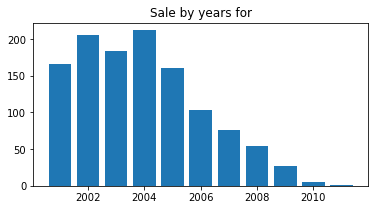

In [16]:
top10_platform = pop_platform[0:10]
data_top10_platform = data.query('platform in @top10_platform.index').reset_index(drop=True)

for platf in top10_platform.index:
    plt.figure(figsize=(6, 3))
    data_top10 = data_top10_platform[data_top10_platform['platform'] == platf]
    data_1 = data_top10.groupby('year_of_release').agg({'sales_sum': 'sum'})
    data_1 = data_1.reset_index()
    #display(data_1) 
    plt.bar("year_of_release", "sales_sum", data=data_1)
    plt.title('Sale by years for', platf)
    plt.xlabel("Year of release")
    plt.ylabel("Sale's sum")
    # ограничим значения оси y, чтобы  потом корректно проводить сравнение
    plt.ylim(0, 250)
    plt.show()


Возможно это самые информативные графики в этом проекте, поэтому сделвем некоторые выводы:
- однозначно общее первое место по продажам PS2 обусловлено высокики цифрами в районе 2001-2005 гг. Очевидно, что в начале двухтысячных у приставки был пик популярности. Дальше дела пошли на спад, и по всей видимости в 2011 году платформа прекратила существование;
- Wii была особо популярна в первые годы существования, в период с 2006 по 2009 год. Продажи были выше 125 миллионов копий. Однако потом виден гиперболический спад (с 2010 по 2016);
- распределение значений у X360 и PS3 весьма схожи и близки к нормальным. Но нужно заметить некое "запаздывание" макисмума у PS3 на год относительно X360;
- DS, как и PS2 до 2016 года "недожила" (закончила существование в 2013), показав пик в районе 2007, 2008 годов и дальнейшее медленное, но верное, затухание;
- в целом значений вышеописанных пяти платформ составляют более 50% продаж от имеющихся у нас данный;
- платформы PS, GBA, PSP когда-то имели неплохие продажи, однако в разные годы все же прекратили свое существование, не достигнув значений вышеописанных топ-5;
- напоследок самое интересное и очень важное, на наш взгляд, в контексте данного исследования. Такая платформа, как PS4 начала свое существование в начале 2010-х годов и надо сказать **имеет очень неплохую динамику к 2017 году**. Что заставляет обратить на нее особое внимание. А вот у 3DS высоких продаж не было и дела ко всему прочему на спад идут, однако в 2016 году еще удалось продать чуть более 10 млн копий.



### Выделение актуального временного периода и анализ продаж

В качетсве актуального примеме период за последние 5 лет и от других данных избавимся.

In [ ]:
data_act = data.query('year_of_release > 2011')
pop_platform_n = data_act.groupby(['platform', 'year_of_release']).agg({'sales_sum': 'sum'})
pop_platform_n

In [ ]:
# строим на всякий случай графики среди других платформ
# вдруг среди них есть будущие лидеры?
tail_platform = pop_platform[11:]
data_untop_platform = data.query('platform in @tail_platform.index').reset_index(drop=True)

for platf in tail_platform.index:
    plt.figure(figsize=(6, 3))
    data_untop = data_untop_platform[data_untop_platform['platform'] == platf]
    data_2 = data_untop.groupby('year_of_release').agg({'sales_sum': 'sum'})
    data_2 = data_2.reset_index()
    #display(data_2) 
    plt.bar("year_of_release", "sales_sum", data=data_2)
    plt.title('Sale by years for', platf)
    plt.xlabel("Year of release")
    plt.ylabel("Sale's sum")
    # ограничим значения оси y, чтобы  потом корректно проводить сравнение
    plt.ylim(0, 70)
    plt.show()

У PC явно никогда больших продаж не было, но при этом стабильность  хорошая, скорее всего и дальше для этой платформы 3-10 млн копий продаваться будет. Далее можно отметить только относительно новую XOne, где в 2016 году продажи еще достигали значения свыше 25 млн копий.

**Итак, выделим следующие платформы, которые скорее всего смогут задавать/поддерживать тренды в 2017 году: PS4 и XOne  (2 группы, смотрящиеся наиболее перспективно), 3DS и  PC (стабильные с небольшими продажами), PSV и WiiU (стабильные с маленькими продажами), X360 и  PS3 (на закате).**

<div class="alert alert-block alert-info"> 
    В описании к сборному проекту на платформе есть интересная фраза "Не учитывайте в работе данные за предыдущие годы."
    Вот мы выделили, показывшиеся нам актуальные данные и далее их уже трогать не будем. Надеюсь это имелось ввиду и далее провожу работу с data_parsed
</div>

In [ ]:
sns.boxplot(x='platform', y='sales_sum', data=data_act)
plt.title('Диаграмма разброса данных для суммарных продаж по платформам')
plt.show()
# явно есть выбросы, и не мало, увеличим масштаб
s_graph = sns.boxplot(x='platform', y='sales_sum', data=data_act)
s_graph.set(ylim=(0,2))
plt.title('Диаграмма разброса данных для суммарных продаж по платформам')
plt.show()

Однозначно аномальные значения скашивают данные вправо. Это говорит о том что много игр, копии которых продавались тиражом не более 0.5 млн (основная масса - для большинства платформ сюда входят около 60-80% значений при чем медианы у всех расположены близко), но существуют также и очень популярные тираж которых выше 2 млн. Выбросы в любом случае тут удалять не совсем правильное дело: есть популярные игры, приносящие особо большие продажи и от них никуда не деться.

In [ ]:
# посмотрим на описание числовых данных в целом
data_act.select_dtypes(include=['float', 'int']).describe()

В связи с разбросом у sales_sum и стандартное отклонение достаточно высокое. Попробуем (возможно пригодиться дальше, а может нет) просто избавиться от всех значений за пределами усов boxplot


Рассмотрим зависимость продаж от оценок (критиков и пользователей соответственно).

In [ ]:
only_platform = data_act[data_act['platform'] == 'PS4']
only_platform.plot(kind='scatter', x='critic_score', y='sales_sum', label='Critic`s score', alpha=0.5)
only_platform.plot( kind='scatter', x='user_score', y='sales_sum', label='User`s score', alpha=0.5)
plt.show()
print("Корреляция по оценкам критиков:", only_platform['critic_score'].corr(only_platform['sales_sum']))
print("Корреляция по оценкам пользователей:", only_platform['user_score'].corr(only_platform['sales_sum']))


plt.figure(figsize=(10, 20))
score_platfs = ['3DS', 'XOne', 'PC', 'PSV', 'WiiU']

for platf in score_platfs:
    graph_platf = data_act[data_act['platform'] == platf]
    graph_platf.plot(kind='scatter', x='critic_score', y='sales_sum',\
                     label='Critic`s score', alpha=0.5, legend=False)
    plt.title(f'Sale`s sum {platf} by critic scores')
    graph_platf.plot(kind='scatter', x='user_score', y='sales_sum',\
                     label='User`s score', alpha=0.5, legend=False)
    plt.title(f'Sale`s sum {platf} by user scores')
    plt.show()
    print("Корреляция платформы", platf,"по оценкам критиков:",\
          graph_platf['critic_score'].corr(graph_platf['sales_sum']))
    print("Корреляция платформы", platf, "по оценкам пользователей:",\
          graph_platf['user_score'].corr(graph_platf['sales_sum']))
    
    

*Для основной платформы*

Отметим, что значительное повышение продаж стимулируется оценками критиков 70 и выше, а у пользователей 6 и выше. Однако у последних кажется, что хаотичность графика повыше: все-таки у сritic_score есть определенная логичная, на наш, взгляд клинообразность значений (в районе 80 и 90 продажи явно выше чем где 70, и рост планомерный; у пользователей для екоторых игр продажи в районе 4-6 самые высокие, без них логичная клиновидность также прослеживается). В целом, следует отметить, что **при увеличении оценок критиков продажи будут расти (корреляция умеренная) пусть и не совсем линейно и повсеместно. Чего нельзя сказать о пользовательских оценках, тут велика вероятность разных вариантов.** 

*Для других выборочных платформ*

Следует подчеркнуть, что для XOne результаты очень схожи с базоыой платформой (у них и продажи по годам были схожими в общем). Но у 3DS, к примеру, корреляция по оценкам критиков падает, а пользователей наоборот возрастает. Для приставки WiiU вообще корреляция по оценкам пользователей уже немного выше. Однако все равно нигде она не достигает сильных значений

Распределение по жанрам:

In [ ]:
sales_by_genre = data_act.groupby('genre').agg({'sales_sum': ['sum', 'count']})
sales_by_genre.columns = ['sum', 'count']
sales_by_genre['relative'] = sales_by_genre['sum'] / sales_by_genre['count']
sales_by_genre = sales_by_genre.sort_values(by=['relative'], ascending=False)
#sales_by_genre = sales_by_genre.reset_index()
sales_by_genre

Заметим, что число игр жанра Action раза в три больше, чем у стоящего на 2 месте по этому показателю Role-Playing. Но продаж при этом больше менее, чем в три раза. А вот Shooter мы бы рекомендовали даже разрабатывать интенсивнее, т.к. у этого жанра отношение суммы проданных копий к общему числу таких игр (sum / count) самое высокое. Игр-приключений достаточно много, однако продажи при этом совсем низкие. Может их и разрабатывать стоит поменьше...

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='genre', y='sales_sum', data=data_act)
plt.title('Диаграмма разброса данных для суммарных продаж по жанрам')
plt.show()
plt.figure(figsize=(12, 5))
genre_graph = sns.boxplot(x='genre', y='sales_sum', data=data_act)
genre_graph.set(ylim=(0,2))
plt.title('Диаграмма разброса данных для суммарных продаж по жанрам')
plt.show()

## Составление портрета пользователя по регионам

Посмотрим на распределение продаж по игровым платформам в целом за актуальное время по регионам. Затем немного "приблизим масштаб", приняв во внимание время и построим соответствующие распредления.

In [ ]:
#data_last_time = data.query('year_of_release > 2011')
data_act.groupby('platform').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'})

In [ ]:
for platf in data_act['platform'].unique():
    data_temp = data_act[data_act['platform'] == platf]
    data_3 = data_temp.groupby('year_of_release').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'})
    data_3 = data_3.reset_index()
    ax = data_3.plot(x="year_of_release", y=['na_sales', 'eu_sales', 'jp_sales'], kind="bar", rot=0, ylim=(0, 50))
    plt.title(platf)
    plt.xlabel("Year of release")
    plt.ylabel("Sale's by region")
    # ограничим значения оси y, чтобы  потом корректно проводить сравнение
    plt.show()

Основные платформы имеют определенных лидеров из числа регионов. Допустим, для PS4 - это Европа (процентов 55-60), для XOne - Северная Америка (процентов 60-70), 3DS - Япония (процентов 40-45). На ПК в Японии не играют совсем (кстати, в этом же регионе чуть больше , чем в других играют в PSP и PSV). В Европе и Америке играют в любые из числа популярных платформ (в PSP и PSV, по всей видимости, совсем мизирное число людей). Все зависит от производителя платформы, его расположения, нацеленности на пользователей в конкретном регионе.

In [ ]:
genre_by_regions = data_act.groupby('genre').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum', 'name': 'count'})
genre_by_regions.sort_values(by='name', ascending=False)

Посмотрим на наиболее прибыльные жанры в разных регионах.

In [ ]:
games_fresh = data_act.copy()
countries = games_fresh.columns[4:7]
# начертим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # выберем 5 самых продающих жанров
  df_i = (games_fresh.groupby('genre')[countries[i]].sum().reset_index().
          sort_values(countries[i], ascending = False, ignore_index = True).
          head(5))
  # занесем все остальыне продажи в другие жанры
  df_i = df_i.append({'genre': 'Other_genre', countries[i]: games_fresh[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
  axs[i].pie(df_i[countries[i]], labels = df_i['genre'], autopct='%1.1f%%')
  # Зададим название региона.
  axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

Однозначно, что в рассматриваемый период времени в жанрах Action выходит больше всего игр и продается копий соответственно. При этом диаграмма по долям говорит нам немного другое, что кроме Action, продуктивен Shooter (в целом в таблице это тоже видно) (см. выводы общей суммы по жанрам sales_by_genre выше). На третьем месте в этих двух регионах стоит Sport (если не учесть other). В японии картина другая - Action любят, но не сильнее, чем Role-Playing.

Здесь все определяется спросом: данный жанр явно охватывает потребности большинства, да и разнообразия в нем много При  этом данный жанр лидер в Европе и Америке по продаажам, а в Японии несколько впереди Role-Playing (регион со своей культурой, сильно отличающейся от Европы и Северной Америки).

Посмотрим на продажи по регионам, группируя их по возрастным категориям.

In [ ]:
data_act.loc[data['rating'].isna(), 'rating'] = 'not defined'
age_category = data_act['rating'].unique()
age_category = list(age_category)
data_act.groupby(['rating']).agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'})

Однозначно в Европе и Северной Америке преобладают продажи в категориях M (для взрослых), Е (для всех) и "not defined" (разница с категориями E10+ и Т в 1.5 и более раза). Т.е. продажи игр для возрастов выше 10, 13 лет не самые высокие. В то же время в  категории М продается в 1,6 и более раза больше, чем в Е. Однако очевидно, что там для большинства игр в Японии этот рейтинг вообще не считается, т.к. продажи игр с неопр. рейтингом там самые высокие, с большим отрывом от других. Также можно сказать, что продажи в целом таких игр по трем регионам распределились достаточно ровно, а в Европе и Северной Америке стоят примерно на равне с категорией М.

## Проверка гипотез

<div class="alert alert-block alert-info"> 
    Сами предложенные варианты на Платформе Yandex несколько привели меня в ступор, т.к. корреляция с продажами оценок пользователей получилась ниже, тогда и гипотезы ароде нужно делать по оценкам критиков. Ну, ладно, возможно ошибся ранее, надеюсь, подскажешь
</div>


### Проверка гипотезы о средних рейтингах XOne и PC

Здесь возникает немного тревожный момент, какой период считать генеральной совокупностью для этих двух платформ. С одной стороны это должне быть весь период из данного нам набора данных. С другой стороны у нас есть актуальный период, по значениям которого логичнее судить о будущем в 2017 году. И мы должны брать его, т.к. XOne существует только с 2012 года. Минус еще в том что данные явно скошены к оценкам 7-8 (скошены влево получается). 


<div class="alert alert-block alert-info"> 
    Возможно стоит от скошенности и избавиться, но это я узнаю, видимо, после проврки, тут оставлю как есть) Везде пока буду рассматривать только данные актуального периода, они кажутся более репрезентативными
</div>


Тогда Н0: средние пользовательские рейтинги платформ XOne и PC одинаковые; Н1: средние пользовательские рейтинги платформ XOne и PC разные.

In [ ]:
u_sccore_xone = data_act[data_act['platform'] == 'XOne']['user_score'].dropna().reset_index(drop=True)
u_sccore_pc = data_act[data_act['platform'] == 'PC']['user_score'].dropna().reset_index(drop=True)

alpha = .05
# выборки схожи и дисперсия, скорее всего, приблизительно равна
# однако в рекомендациях указано, что при разных по размерах выборках
# нужно учитывать, что они могут быть разными
results = st.ttest_ind(u_sccore_xone, u_sccore_pc, equal_var = False)

print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Можем отвергнуть Н0')
else:
    print('Нельзя отвергнуть Н0')


Очевидно, что p-value очень высокое и означает, что примерно в 50% случаев произойдет так, как гласит нулевая гипотеза.
Калькулятор https://www.evanmiller.org/ab-testing/t-test.html дал тот же результат но в какой-то мере нагляднее. Если постмотреть по средним разница действительно невелика и лежат они очень близко, что подкрепляет высокую вероятность того, что редние пользовательские рейтинги платформ XOne и PC одинаковые. *С такой небольшой выборкой можно просто средние посчитать, т.к. оперативка явно такое тянет*

### Прверка гипотезы о средних рейтингах жанров Sports и Action

В данной постановке все менее однозначно, в отличие от платформ жанры существовали всегда и очевидно что разница результатов теста по разным датафреймам будет. Но с учетом сказанного выше разбиарем только data_parsed и тестируем его данные.

Тогда Н0: средние пользовательские рейтинги жанров Sports и Action одинаковые; Н1: средние пользовательские рейтинги жанров Sports и Action разные.

In [ ]:
u_score_action = data_act[data_act['genre'] == 'Action']['user_score'].dropna().reset_index(drop=True)
u_score_sports = data_act[data_act['genre'] == 'Sports']['user_score'].dropna().reset_index(drop=True)

alpha = .05
results = st.ttest_ind(u_score_action, u_score_sports, equal_var = False)

print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Можем отвергнуть Н0')
else:
    print('Нельзя отвергнуть Н0')

print("Расчетные средние:", '{0:.3f}'.format(u_score_sports.mean()),'и' , '{0:.3f}'.format(u_score_action.mean()))


Здесь вывели средние и разница реально видна. Поэтому с подкрепленной уверенностью (нв уровне значимости 5%) есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы

Нулевая гипотеза в обоих случаях формировалась согласно рекомендациям Спринта 6 Темы 4 урока 6 "H₀ всегда формулируется так, чтобы использовать знак равенства." В предложенных в задании вариантах везде говорится о средних (просто по разным показателям), поэтому их и приравниваем. Логично, что альтернативная гипотеза двусторонняя, потому что мы не знаем, куда может быть смещено одно среднее относительно другого. В качестве критерия используем p-value (уровень значимости), который показывает вероятность получить наблюдаемый результат при условии, что H0 верна. А метод ttest_ind подходит, т.к. выборки как бы из двух независимых генеральных совокупностей

## Вывод

В итоге получаем следующие важные результаты: 
  - были обработаны некоторые пропуски (в том числе такой специфичный как "tbd" в оценках пользователей) и данные приведены к нужным типам;
  - установлено что пик выпуска игр на всех платформах оказался в районе 2008, 2009 гг.;
  - оказалось что топ-5 платформ за пследние 20 лет (от 2016 года) имеют существенное превосходство в сравнении с другими (это PS2, X360, PS3, Wii, DS), однако некоторые к данному моменту времени (DS, PS2) даже прекратили свое существование, у остальных (X360, PS3, Wii) продажи к 2016 только падают и очень низкие в сравнении с пиковыми;
  - в то же время есть такие платформы как XOne, PS4, 3DS, продажи которых сохраняют достаточно высокие значения в определенный нами актуальный период (начиная с 2012 года). Сразу же отметим, что именно эти типы игровых брендов захватили лидерство по регионам - в Северной Америке, Европе и Японии соответственно. В 2017 году, скорее всего, смогут задавать/поддерживать тренды: PS4 и XOne (2 группы, смотрящиеся наиболее перспективно), 3DS и PC (стабильные с небольшими продажами), PSV и WiiU (стабильные с маленькими продажами);
  - копии болшинства игр продавались тиражом не более 0.5 млн (для актуальных к 2016 году платформ сюда входят около 60-80% значений при чем медианы у всех расположены близко друг к другу в районе 0,2-0,35 млн копий);
  - продажи у некоторых платформ растут при высоких оценках критиков, есть умеренная линейная корреляция для перспективных платформ PS4 и XOne. В принципе и при повышенных оценках пользователей продажи многих игр на платформах повышены, однако разброс по ним в общем случае выше;
  - чаще всего выппускаются игры жанра Action, однако у них не самые высокие относительные продажи, Shooter в это плане эффективнее. У пользователей разных регионов определенно есть свои предпочтения в жанрах (в Японии любят Role-Playing, в Америке и Европе Action и Shooter);
  - допущена нулевая гипотез о том, что средние пользовательские рейтинги платформ XOne и PC одинаковые;
  - отвергнута нулевая гипотез о том, что средние пользовательские рейтинги жанров Sports и Action одинаковые.